In [1]:
import random

random.seed(42)

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LassoCV, LinearRegression, RidgeCV
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.preprocessing import StandardScaler

# sharper plots
%config InlineBackend.figure_format = 'retina'


def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [2]:
df = pd.read_csv(
    "../../_static/data/assignment9/ads_hour.csv", index_col=["Date"], parse_dates=["Date"]
)

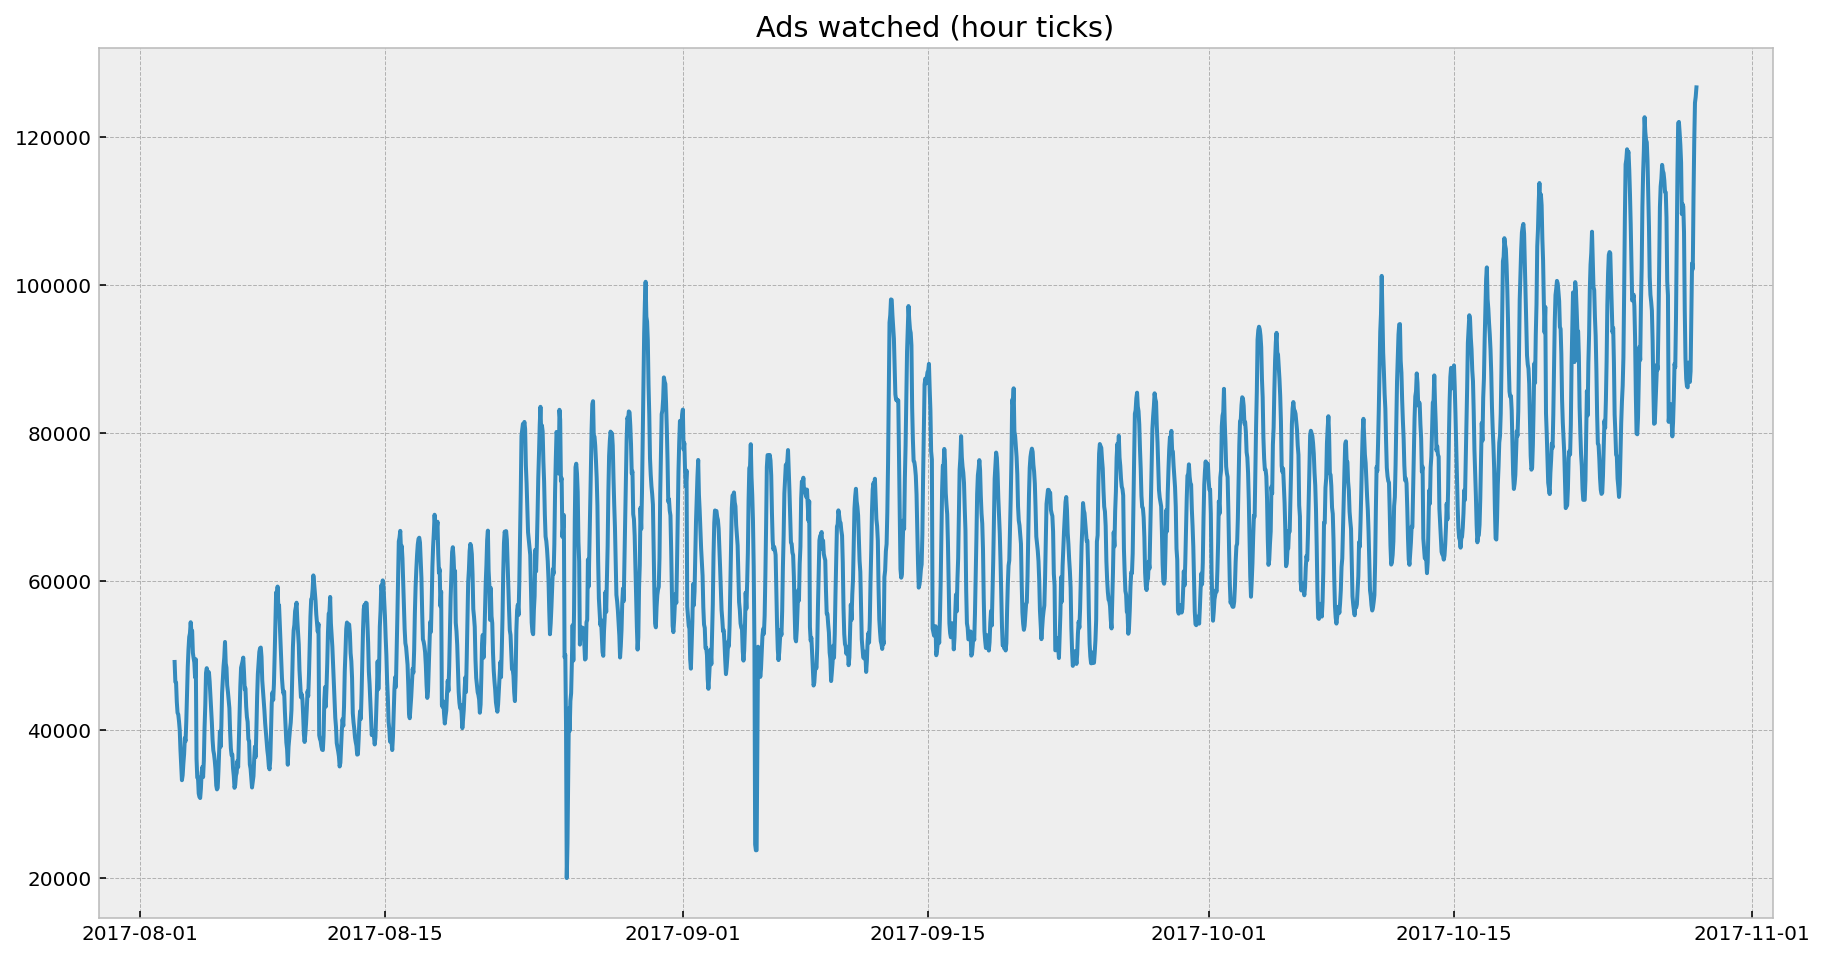

In [3]:
with plt.style.context("bmh"):
    plt.figure(figsize=(15, 8))
    plt.title("Ads watched (hour ticks)")
    plt.plot(df.ads);

In [4]:
def prepareData(data, lag_start=5, lag_end=14, test_size=0.15):
    """
    series: pd.DataFrame
        dataframe with timeseries

    lag_start: int
        initial step back in time to slice target variable 
        example - lag_start = 1 means that the model 
                  will see yesterday's values to predict today

    lag_end: int
        final step back in time to slice target variable
        example - lag_end = 4 means that the model 
                  will see up to 4 days back in time to predict today

    test_size: float
        size of the test dataset after train/test split as percentage of dataset

    """
    data = pd.DataFrame(data.copy())
    data.columns = ["y"]

    # calculate test index start position to split data on train test
    test_index = int(len(data) * (1 - test_size))

    # adding lags of original time series data as features
    for i in range(lag_start, lag_end):
        data["lag_{}".format(i)] = data.y.shift(i)

    # transforming df index to datetime and creating new variables
    data.index = pd.to_datetime(data.index)
    data["hour"] = data.index.hour
    data["weekday"] = data.index.weekday

    # since we will be using only linear models we need to get dummies from weekdays
    # to avoid imposing weird algebraic rules on day numbers
    data = pd.concat(
        [
            data.drop("weekday", axis=1),
            pd.get_dummies(data["weekday"], prefix="weekday"),
        ],
        axis=1,
    )

    # encode hour with sin/cos transformation
    # credits - https://ianlondon.github.io/blog/encoding-cyclical-features-24hour-time/
    data["sin_hour"] = np.sin(2 * np.pi * data["hour"] / 24)
    data["cos_hour"] = np.cos(2 * np.pi * data["hour"] / 24)
    data.drop(["hour"], axis=1, inplace=True)

    data = data.dropna()
    data = data.reset_index(drop=True)

    # splitting whole dataset on train and test
    X_train = data.loc[:test_index].drop(["y"], axis=1)
    y_train = data.loc[:test_index]["y"]
    X_test = data.loc[test_index:].drop(["y"], axis=1)
    y_test = data.loc[test_index:]["y"]

    return X_train, X_test, y_train, y_test

In [5]:
# You code here (read-only in a JupyterBook, pls run jupyter-notebook to edit)
# X_train, X_test, y_train, y_test =

In [6]:
# You code here (read-only in a JupyterBook, pls run jupyter-notebook to edit)

In [7]:
# You code here (read-only in a JupyterBook, pls run jupyter-notebook to edit)
tscv = None  # change this

In [8]:
def plotModelResults(
    model, df_train, df_test, y_train, y_test, plot_intervals=False, scale=1.96, cv=tscv
):
    """
    Plots modelled vs fact values
    
    model: fitted model 
    
    df_train, df_test: splitted featuresets
    
    y_train, y_test: targets
    
    plot_intervals: bool, if True, plot prediction intervals
    
    scale: float, sets the width of the intervals
    
    cv: cross validation method, needed for intervals
    
    """
    # making predictions for test
    prediction = model.predict(df_test)

    plt.figure(figsize=(20, 7))
    plt.plot(prediction, "g", label="prediction", linewidth=2.0)
    plt.plot(y_test.values, label="actual", linewidth=2.0)

    if plot_intervals:
        # calculate cv scores
        cv = cross_val_score(
            model, df_train, y_train, cv=cv, scoring="neg_mean_squared_error"
        )

        # calculate cv error deviation
        deviation = np.sqrt(cv.std())

        # calculate lower and upper intervals
        lower = prediction - (scale * deviation)
        upper = prediction + (scale * deviation)

        plt.plot(lower, "r--", label="upper bond / lower bond", alpha=0.5)
        plt.plot(upper, "r--", alpha=0.5)

    # calculate overall quality on test set
    mae = mean_absolute_error(prediction, y_test)
    mape = mean_absolute_percentage_error(prediction, y_test)
    plt.title("MAE {}, MAPE {}%".format(round(mae), round(mape, 2)))
    plt.legend(loc="best")
    plt.grid(True);

In [9]:
def getCoefficients(model):
    """Returns sorted coefficient values of the model"""
    coefs = pd.DataFrame(model.coef_, X_train.columns)
    coefs.columns = ["coef"]
    coefs["abs"] = coefs.coef.apply(np.abs)
    return coefs.sort_values(by="abs", ascending=False).drop(["abs"], axis=1)


def plotCoefficients(model):
    """Plots sorted coefficient values of the model"""
    coefs = getCoefficients(model)

    plt.figure(figsize=(20, 7))
    coefs.coef.plot(kind="bar")
    plt.grid(True, axis="y")
    plt.hlines(y=0, xmin=0, xmax=len(coefs), linestyles="dashed")
    plt.show()

In [10]:
# You code here (read-only in a JupyterBook, pls run jupyter-notebook to edit)

In [11]:
# You code here (read-only in a JupyterBook, pls run jupyter-notebook to edit)

In [12]:
# You code here (read-only in a JupyterBook, pls run jupyter-notebook to edit)

In [13]:
# You code here (read-only in a JupyterBook, pls run jupyter-notebook to edit)

In [14]:
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline


def plotPCA(pca):
    """
    Plots accumulated percentage of explained variance by component
    
    pca: fitted PCA object
    """
    components = range(1, pca.n_components_ + 1)
    variance = np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4) * 100)
    plt.figure(figsize=(20, 10))
    plt.bar(components, variance)

    # additionally mark the level of 95% of explained variance
    plt.hlines(y=95, xmin=0, xmax=len(components), linestyles="dashed", colors="red")

    plt.xlabel("PCA components")
    plt.ylabel("variance")
    plt.xticks(components)
    plt.show()

In [15]:
# Create PCA object: pca


# Train PCA on scaled data


# plot explained variance

In [16]:
# You code here (read-only in a JupyterBook, pls run jupyter-notebook to edit)

In [17]:
# You code here (read-only in a JupyterBook, pls run jupyter-notebook to edit)

In [18]:
# You code here (read-only in a JupyterBook, pls run jupyter-notebook to edit)